In [1]:
import pickle
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, r2_score

from keras import Model, Sequential
from keras import metrics
from keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [2]:
# carregar os dados de entrada
inputs_file = 'input_db_29_08_2023_14_26_20.pkl'
with open(inputs_file, 'rb') as handle_inputs:
    inputs = pickle.load(handle_inputs)

In [3]:
inputs.head()

,site_lat,site_long,sat_long,freq,eirp,hsat,bw_total,bw_util,rolloff,mod,fec,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,35786,36,16.155547,0.2,32APSK,126/180,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,35786,36,22.226415,0.2,32APSK,135/180,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518
2,-19.167619,-34.986496,-2.622435,5.349325,56.252903,35786,36,35.827805,0.2,64APSK,162/180,19.590329,1.207189,0.530488,57.036432,28.600282,5.894995,1.506105
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,35786,36,14.203504,0.2,8PSK,100/180,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,35786,36,9.488156,0.2,32APSK,126/180,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052


In [4]:
inputs = inputs.drop(columns=["hsat", "bw_total", "mod", "fec", "rolloff"])

In [5]:
# carregar os dados de saída -
# apenas a coluna availability é relevante para o problema,
# pode-se ignorar as demais para o treinamento e teste
results_file = 'results_db_29_08_2023_14_26_20.pkl'
with open(results_file, 'rb') as handle_results:
    results = pickle.load(handle_results)

In [6]:
results.head()

,availability,a_fs,a_g,a_c,a_r,a_s,a_t,a_tot,a_depoint,c_n0,...,earth_radius,elevation_angle,distance,fig_merit,noise_ground,noise_sky,ant_noise,noise_total,ant_gain,ant_3db
0,99.904,207.841452,0.322924,0.966845,9.079432,0.526741,10.383000,220.241483,2.017030,84.759447,...,6367.489544,43.741256,37499.215397,24.276649,10.0,10.860506,260.815713,286.308799,43.398944,1.263074
1,99.999,201.903879,0.065287,0.201974,7.102761,0.439884,7.383255,277.812514,68.525380,112.688241,...,6367.489544,56.474767,36698.322584,95.134206,10.0,3.208548,235.351027,248.680367,46.873483,0.591097
2,96.460,198.393586,0.065097,0.039061,0.016178,0.116006,0.193583,201.164695,2.577525,-99916.332614,...,6367.489544,47.007765,37271.796260,-100000.000000,10.0,3.867110,25.687222,54.289160,33.854824,3.249709
3,99.999,206.567603,0.201870,0.712902,27.381892,0.930295,28.312062,241.951596,7.071931,86.145051,...,6367.489544,59.412644,36547.299501,23.855004,10.0,5.183472,284.602019,314.728183,39.509835,1.408672
4,99.990,207.986262,0.381950,1.032110,16.817812,0.716087,18.246230,232.308445,6.075953,82.544269,...,6367.489544,37.330831,37986.968867,26.033504,10.0,12.583786,281.070225,302.118263,43.249134,0.517240


In [7]:
# preprocessamento da base de dados -
# as linhas cuja coluna fig_merit têm valor igual a -100000
# são casos inválidos e devem ser removidos
filter_matrix = results.fig_merit != -100000
print(filter_matrix.head())
print(np.sum(filter_matrix))

0     True
1     True
2    False
3     True
4     True
Name: fig_merit, dtype: bool
1457619


In [8]:
filtered_inputs = inputs[filter_matrix]
filtered_results = results[filter_matrix]

In [9]:
print(filtered_inputs.shape)
print(inputs.shape)

print(filtered_results.shape)
print(results.shape)

(1457619, 13)
(1880000, 13)
(1457619, 21)
(1880000, 21)


           site_lat     site_long      sat_long          freq          eirp  \
count  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean  -1.505471e+01 -5.330440e+01 -5.230916e+01  1.132981e+01  5.091215e+01   
std    1.061157e+01  1.080609e+01  3.258509e+01  4.041949e+00  1.763086e+01   
min   -3.368997e+01 -7.288998e+01 -1.079999e+02  3.000049e+00  1.500033e+01   
25%   -2.430390e+01 -6.240066e+01 -8.093161e+01  7.965716e+00  3.691857e+01   
50%   -1.470179e+01 -5.317498e+01 -5.223987e+01  1.150008e+01  5.183633e+01   
75%   -5.817384e+00 -4.398199e+01 -2.366515e+01  1.483480e+01  6.597661e+01   
max    2.819986e+00 -3.480004e+01  2.999920e+00  1.799999e+01  7.999994e+01   

            bw_util  snr_threshold      ant_size       ant_eff      lnb_gain  \
count  1.457619e+06   1.457619e+06  1.457619e+06  1.457619e+06  1.457619e+06   
mean   1.850569e+01   8.798743e+00  2.383836e+00  5.565397e-01  5.999881e+01   
std    1.009771e+01   5.843946e+00  1.251949e+00

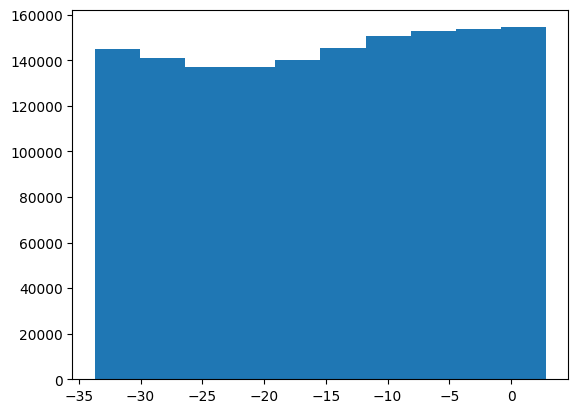

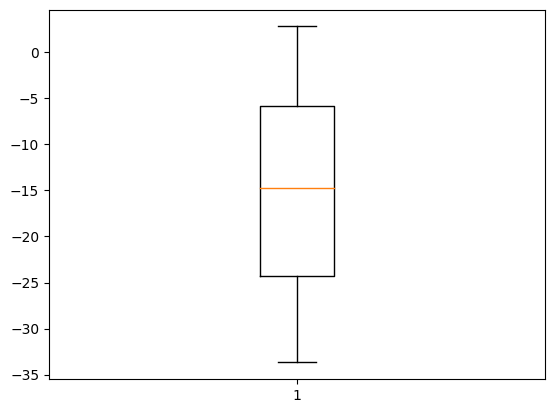

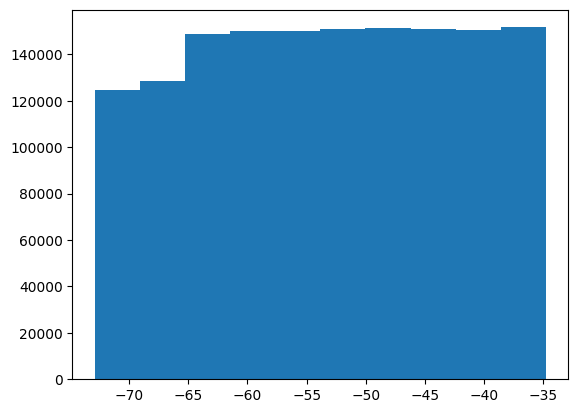

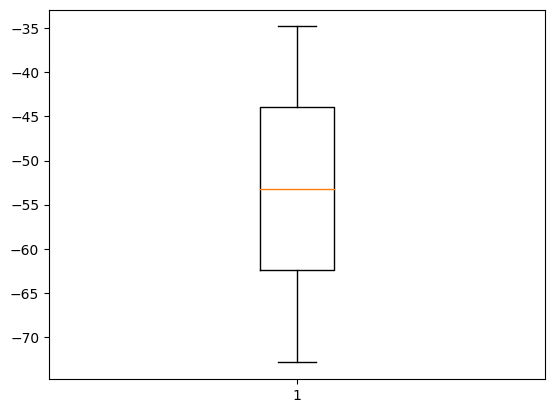

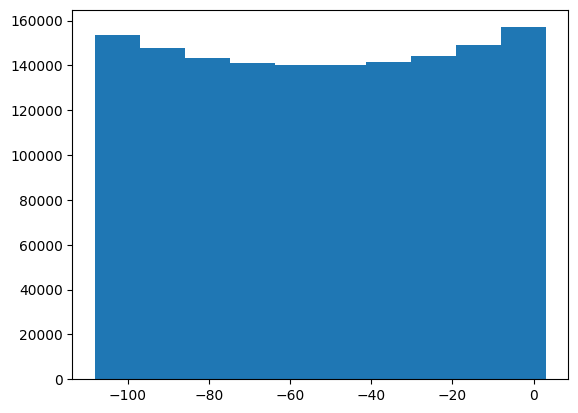

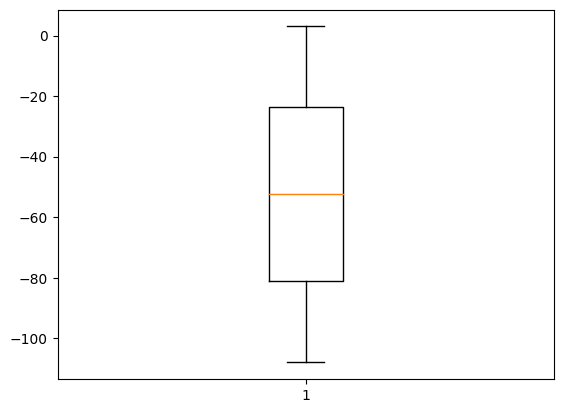

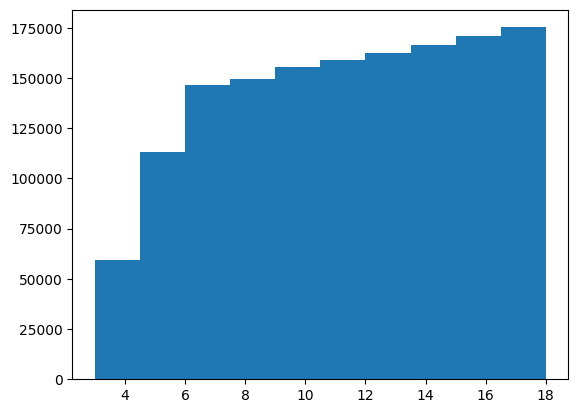

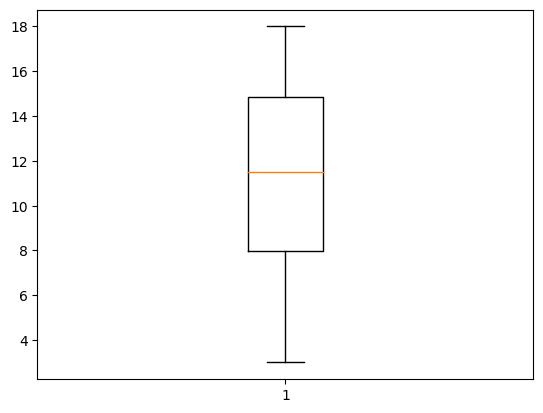

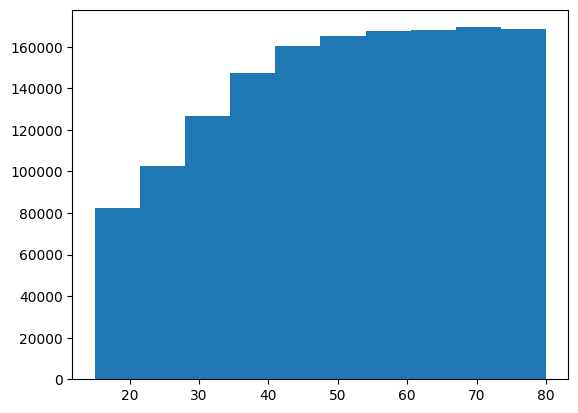

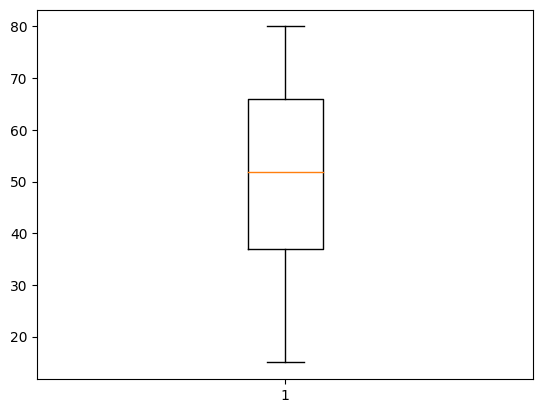

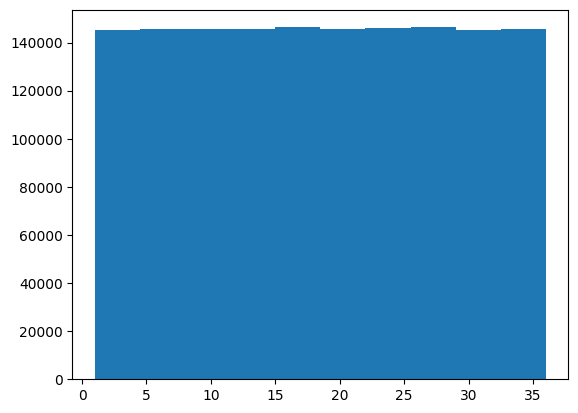

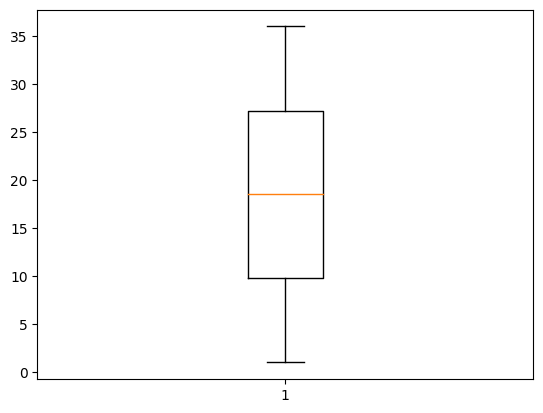

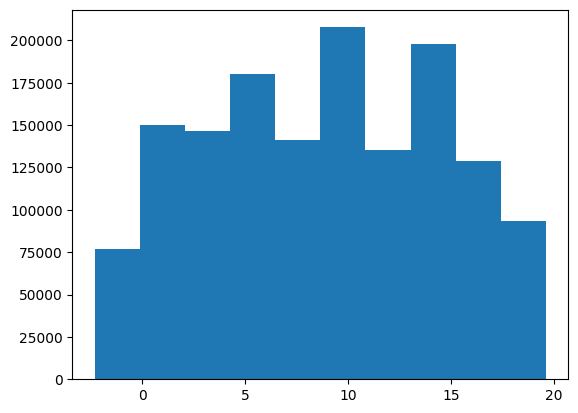

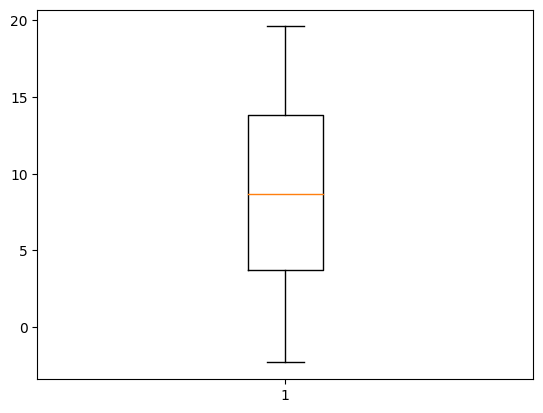

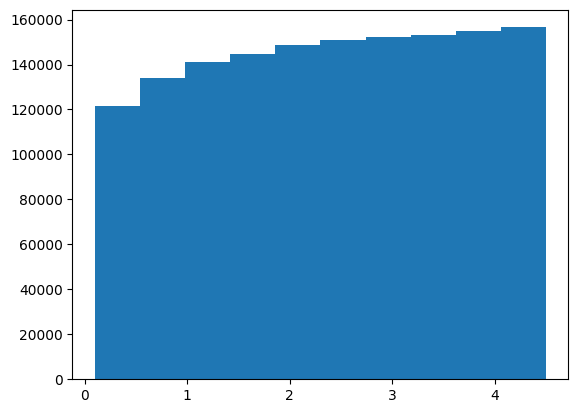

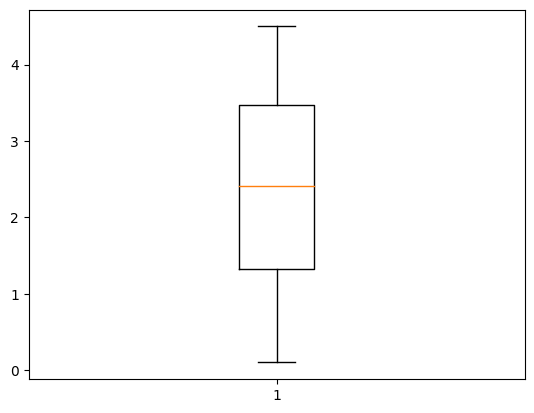

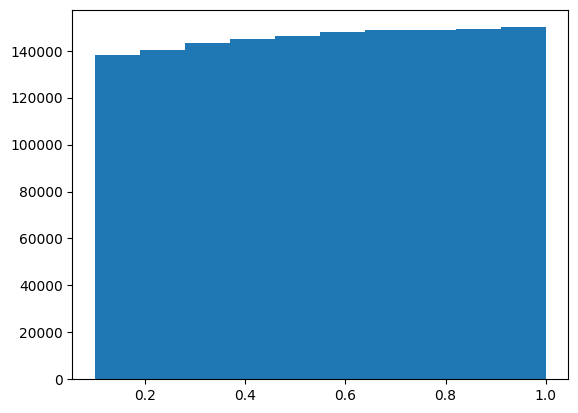

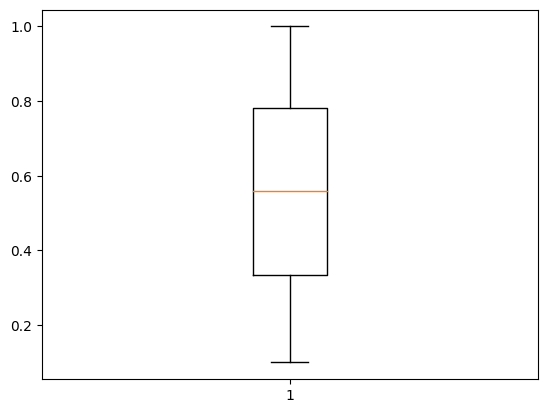

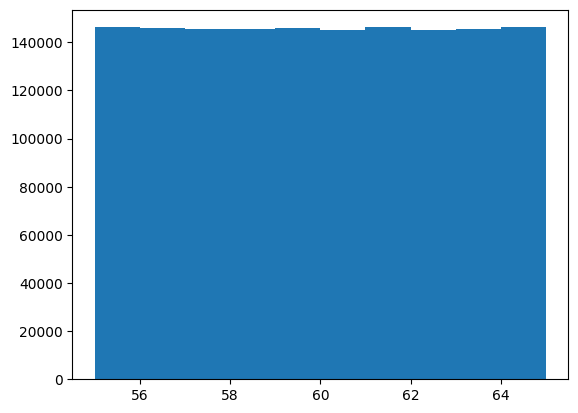

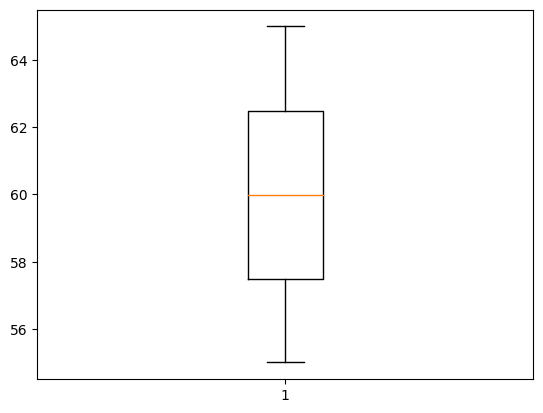

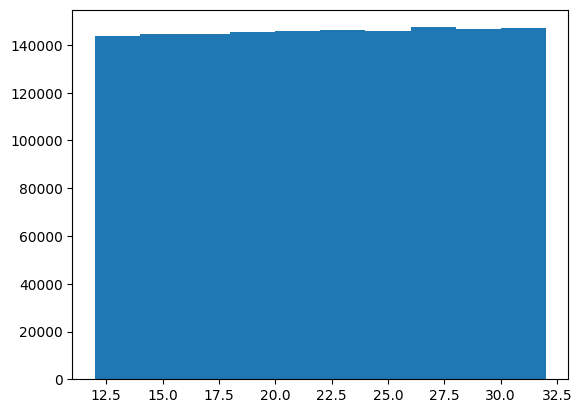

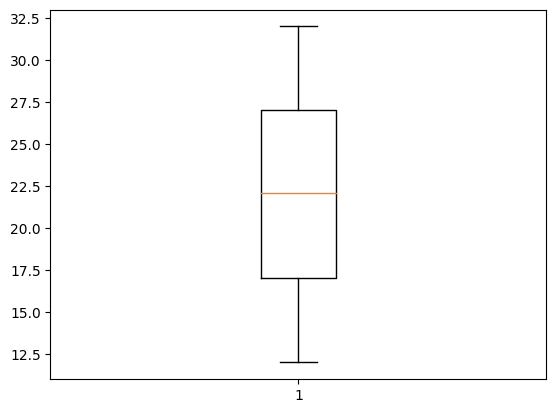

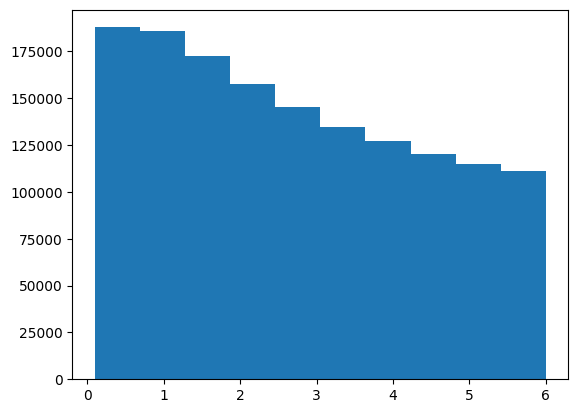

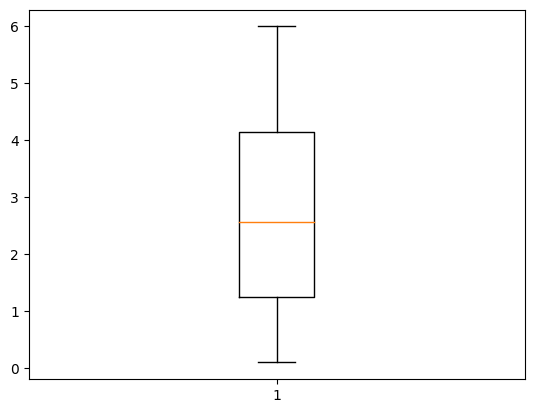

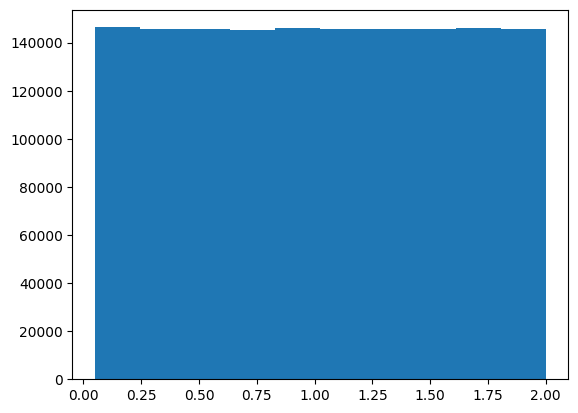

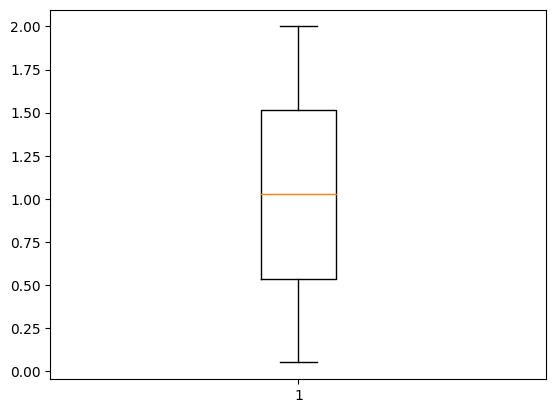

In [10]:
print(filtered_inputs.describe())
for column in inputs.columns:
    # Creating plot
    plt.hist(filtered_inputs[column])
    plt.show()
    plt.boxplot(filtered_inputs[column])
    plt.show()

In [11]:
df = filtered_inputs.assign(availability=filtered_results["availability"])
df.head()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint,availability
0,-16.284610,-53.833962,-16.791579,15.777944,55.604089,16.155547,12.731030,1.053027,0.721533,60.752933,25.492447,5.587639,0.517839,99.904
1,-19.589594,-47.124346,-25.670642,8.138563,68.860880,22.226415,13.567632,4.362265,0.351699,58.632002,13.328408,5.246875,1.412518,99.999
3,-7.438339,-65.779685,-40.611067,13.980570,79.680713,14.203504,5.407456,1.065575,0.366528,62.943757,30.125849,4.965485,1.081404,99.999
4,-31.421909,-51.281737,-86.449047,15.837202,66.010417,9.488156,12.731030,2.561817,0.116897,56.777167,21.047025,4.254455,0.368052,99.990
5,-17.303467,-41.668725,-66.343144,12.480028,27.720772,31.814645,8.326742,4.452849,0.583401,64.208048,17.289375,2.862834,1.010339,99.554


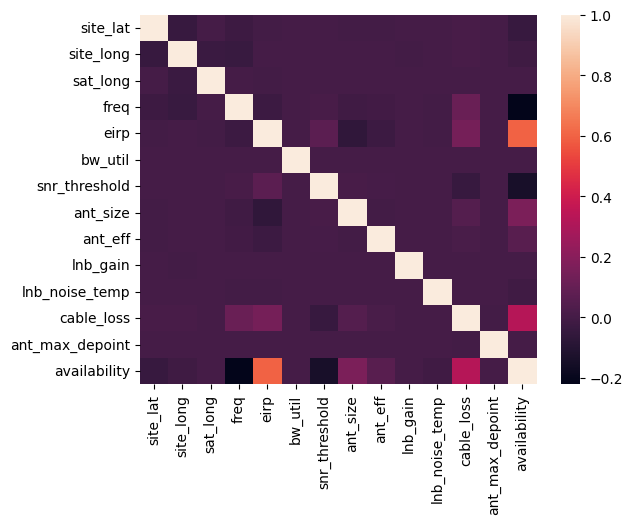

In [12]:
sns.heatmap(df.corr())
plt.show()

In [13]:
# setando a semente para divisão dos conjuntos de treino e teste
np.random.seed(0)

In [14]:
# separando os dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(filtered_inputs, filtered_results['availability'], test_size=0.3)

In [15]:
# alguns dados estatisticos por atributo
x_train.describe()

,site_lat,site_long,sat_long,freq,eirp,bw_util,snr_threshold,ant_size,ant_eff,lnb_gain,lnb_noise_temp,cable_loss,ant_max_depoint
count,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06,1.020333e+06
mean,-1.504772e+01,-5.330588e+01,-5.232426e+01,1.132511e+01,5.091769e+01,1.850174e+01,8.806403e+00,2.383454e+00,5.563931e-01,5.999979e+01,2.204284e+01,2.733932e+00,1.025267e+00
std,1.060838e+01,1.080360e+01,3.258665e+01,4.042685e+00,1.763187e+01,1.009940e+01,5.841575e+00,1.251882e+00,2.587873e-01,2.889218e+00,5.774551e+00,1.692195e+00,5.633380e-01
min,-3.368997e+01,-7.288997e+01,-1.079999e+02,3.000049e+00,1.500033e+01,1.000003e+00,-2.297824e+00,1.000031e-01,1.000027e-01,5.500000e+01,1.200001e+01,1.000104e-01,5.000065e-02
25%,-2.428984e+01,-6.240017e+01,-8.094459e+01,7.956850e+00,3.692215e+01,9.761410e+00,3.744510e+00,1.319732e+00,3.339793e-01,5.749908e+01,1.704969e+01,1.248886e+00,5.364490e-01
50%,-1.469600e+01,-5.318309e+01,-5.227916e+01,1.149507e+01,5.184055e+01,1.850132e+01,8.670497e+00,2.411449e+00,5.593226e-01,5.999936e+01,2.206716e+01,2.559088e+00,1.025690e+00
75%,-5.811759e+00,-4.398441e+01,-2.368129e+01,1.482919e+01,6.598719e+01,2.724314e+01,1.382831e+01,3.468151e+00,7.804111e-01,6.250244e+01,2.704791e+01,4.145020e+00,1.513530e+00
max,2.819986e+00,-3.480007e+01,2.999885e+00,1.799997e+01,7.999990e+01,3.599998e+01,1.959033e+01,4.499999e+00,9.999982e-01,6.499998e+01,3.199995e+01,5.999996e+00,1.999997e+00


In [16]:
y_train.describe()

count    1.020333e+06
mean     9.929236e+01
std      1.374988e+00
min      9.500100e+01
25%      9.964200e+01
50%      9.999200e+01
75%      9.999900e+01
max      9.999900e+01
Name: availability, dtype: float64

(array([ 12412.,  39148.,  53449.,  54182.,   4874.,   7050.,   9982.,
         14935.,  37860., 786441.]),
 array([95.001 , 95.5008, 96.0006, 96.5004, 97.0002, 97.5   , 97.9998,
        98.4996, 98.9994, 99.4992, 99.999 ]),
 <BarContainer object of 10 artists>)

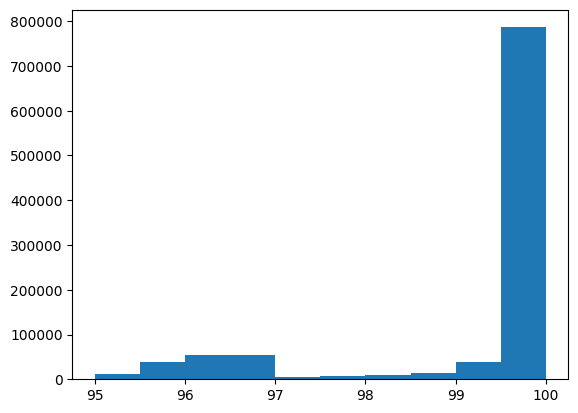

In [17]:
plt.hist(y_train)

In [18]:
y_test.describe()

count    437286.000000
mean         99.292407
std           1.374862
min          95.000000
25%          99.643000
50%          99.992000
75%          99.999000
max          99.999000
Name: availability, dtype: float64

(array([  5180.,  16403.,  23049.,  23664.,   2062.,   3048.,   4195.,
          6479.,  16001., 337205.]),
 array([95.    , 95.4999, 95.9998, 96.4997, 96.9996, 97.4995, 97.9994,
        98.4993, 98.9992, 99.4991, 99.999 ]),
 <BarContainer object of 10 artists>)

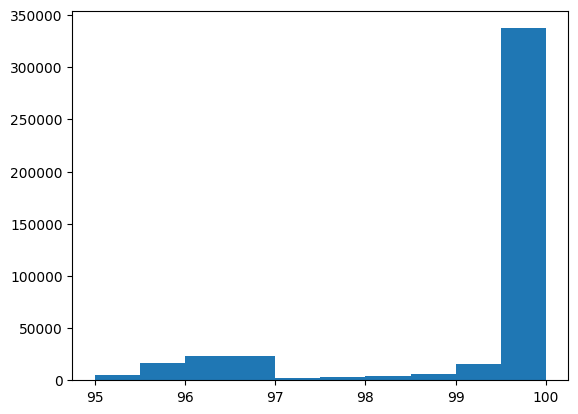

In [19]:
plt.hist(y_test)

In [20]:
# normalização dos dados
preprocessParams = preprocessing.StandardScaler().fit(x_train)
x_train_normalized = preprocessParams.transform(x_train)
x_test_normalized = preprocessParams.transform(x_test)

In [21]:
y_train_num = pd.to_numeric(y_train)
y_train_df = pd.DataFrame(y_train_num)
y_test_num = pd.to_numeric(y_test)
y_test_df = pd.DataFrame(y_test_num)

preprocessParamsY = preprocessing.StandardScaler().fit(y_train_df)
y_train_normalized = preprocessParamsY.transform(y_train_df)
y_test_normalized = preprocessParamsY.transform(y_test_df)

(array([ 12412.,  39148.,  53449.,  54182.,   4874.,   7050.,   9982.,
         14935.,  37860., 786441.]),
 array([-3.1210207 , -2.75752653, -2.39403236, -2.03053819, -1.66704402,
        -1.30354985, -0.94005568, -0.57656151, -0.21306734,  0.15042682,
         0.51392099]),
 <BarContainer object of 10 artists>)

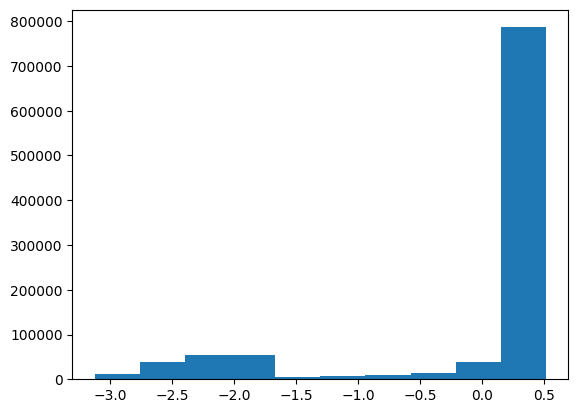

In [22]:
plt.hist(y_train_normalized)

(array([  5180.,  16403.,  23049.,  23664.,   2062.,   3048.,   4195.,
          6479.,  16001., 337205.]),
 array([-3.12174798, -2.75818108, -2.39461419, -2.03104729, -1.66748039,
        -1.30391349, -0.9403466 , -0.5767797 , -0.2132128 ,  0.1503541 ,
         0.51392099]),
 <BarContainer object of 10 artists>)

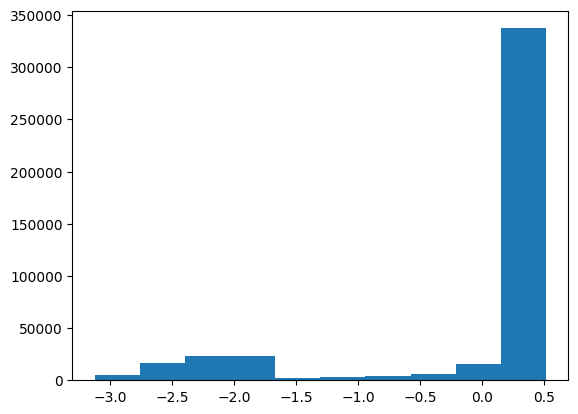

In [23]:
plt.hist(y_test_normalized)

In [24]:
x_train_normalized.shape[1:]

(13,)

In [25]:
# teste de rede neural
RN = Sequential()
RN.add(Dense(512, input_shape = x_train_normalized.shape[1:], activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(256, activation = 'sigmoid'))
RN.add(Dropout(0.05))
RN.add(Dense(1))
RN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               7168      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 138753 (542.00 KB)
Trainable params: 138753 (542.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
# treinamento
RN.compile(optimizer='Adam', loss='mean_squared_error', metrics=['mape', 'mae', 'msle', 'log_cosh', 'cosine_proximity'])
history = RN.fit(x_train_normalized, y_train_normalized, epochs=200, validation_split=0.2)

Epoch 1/200
25509/25509 [==============================] - 26s 1ms/step - loss: 0.1744 - mape: 72.0639 - mae: 0.1989 - msle: 0.0090 - log_cosh: 0.0669 - cosine_proximity: 0.8751 - val_loss: 0.1169 - val_mape: 41.3084 - val_mae: 0.1348 - val_msle: 0.0038 - val_log_cosh: 0.0448 - val_cosine_proximity: 0.9318
Epoch 2/200
25509/25509 [==============================] - 25s 996us/step - loss: 0.1018 - mape: 48.3794 - mae: 0.1409 - msle: 0.0043 - log_cosh: 0.0408 - cosine_proximity: 0.9297 - val_loss: 0.0768 - val_mape: 37.8045 - val_mae: 0.1164 - val_msle: 0.0035 - val_log_cosh: 0.0317 - val_cosine_proximity: 0.9416
Epoch 3/200
25509/25509 [==============================] - 26s 1ms/step - loss: 0.0811 - mape: 40.0614 - mae: 0.1256 - msle: 0.0035 - log_cosh: 0.0335 - cosine_proximity: 0.9426 - val_loss: 0.0663 - val_mape: 36.2502 - val_mae: 0.1126 - val_msle: 0.0031 - val_log_cosh: 0.0280 - val_cosine_proximity: 0.9474
Epoch 4/200
25509/25509 [==============================] - 26s 1ms/step - 

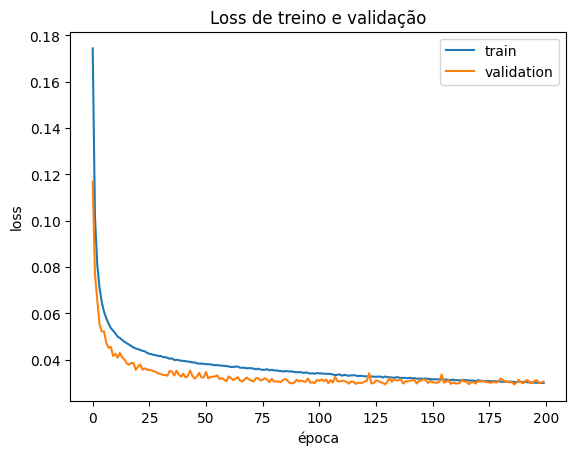

In [27]:
# gráfico do treinamento: custo do treino e validação
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss de treino e validação')
plt.ylabel('loss')
plt.xlabel('época')
plt.legend();

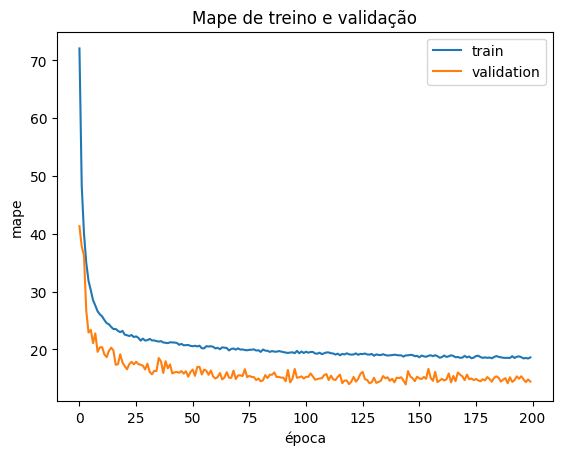

In [28]:
# gráfico do treinamento: mape do treino e validação
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('Mape de treino e validação')
plt.ylabel('mape')
plt.xlabel('época')
plt.legend();

In [29]:
# avaliação
score = RN.evaluate(x_train_normalized, y_train_normalized, verbose = 0)
print('Train score:', score[0])
print('Train mape:', score[1], '%')

Train score: 0.02428419515490532
Train mape: 13.542359352111816 %


In [30]:
# avaliação
score = RN.evaluate(x_test_normalized, y_test_normalized, verbose = 0)
print('Test score:', score[0])
print('Test mape:', score[1], '%')

Test score: 0.031101901084184647
Test mape: 14.700553894042969 %


31886/31886 [==============================] - 11s 350us/step


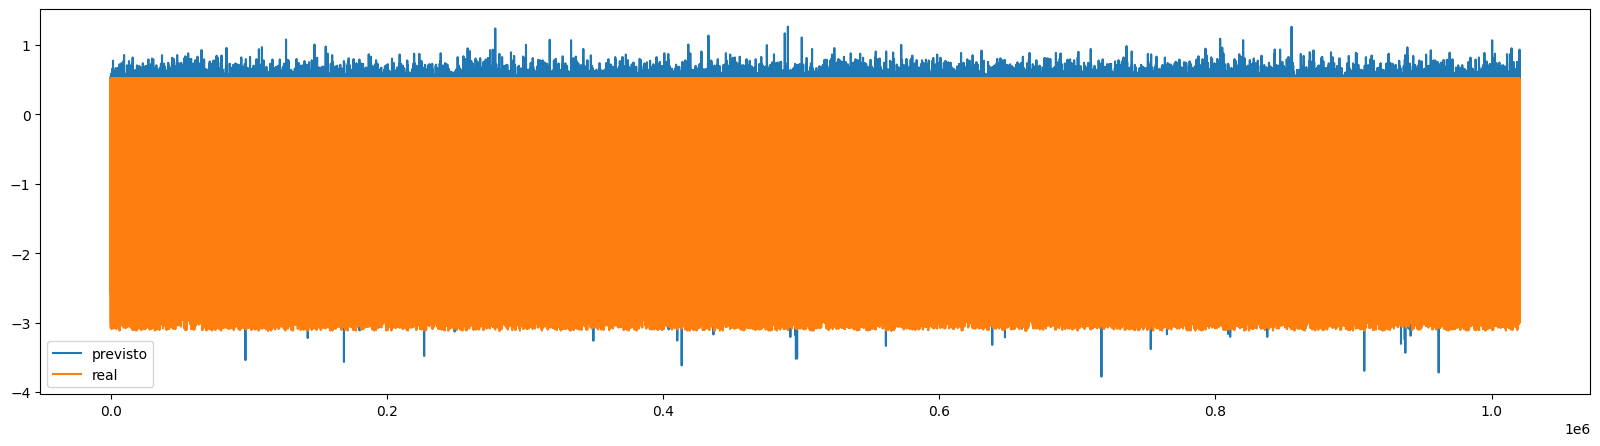

In [31]:
# avaliação gráfica
y_train_predicted = RN.predict(x_train_normalized)

results_train = pd.DataFrame(y_train_predicted, columns = ['previsto'])
results_train['real'] = np.array(y_train_normalized)
results_train.plot(figsize=(20,5)); # todas as previsões

13666/13666 [==============================] - 5s 347us/step


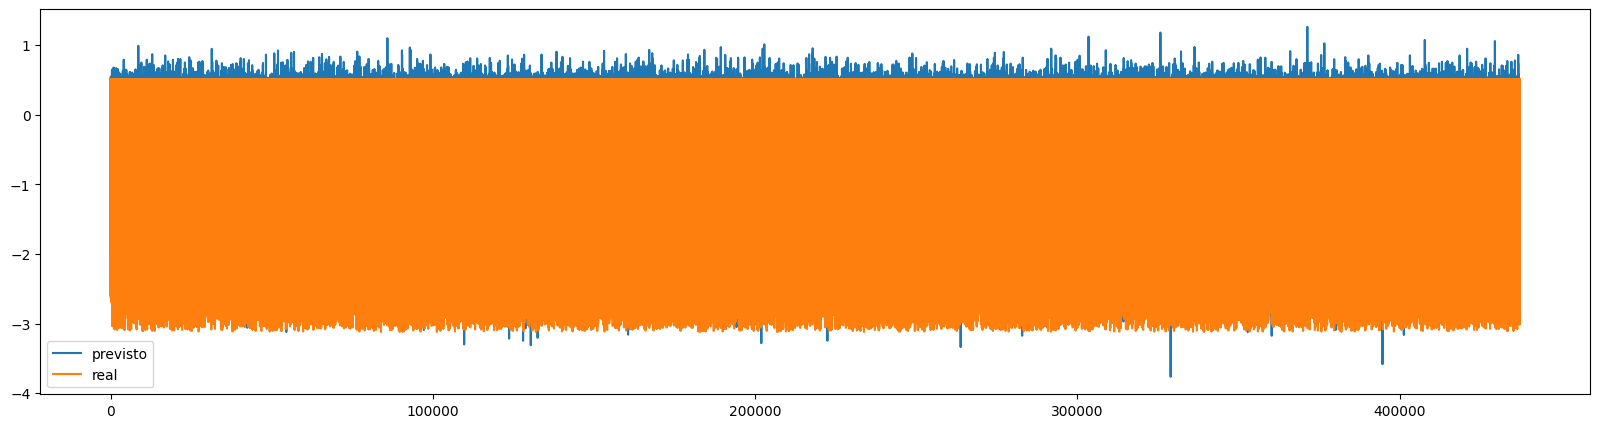

In [32]:
# avaliação gráfica
y_test_predicted = RN.predict(x_test_normalized)

results = pd.DataFrame(y_test_predicted, columns = ['previsto'])
results['real'] = np.array(y_test_normalized)
results.plot(figsize=(20,5)); # todas as previsões

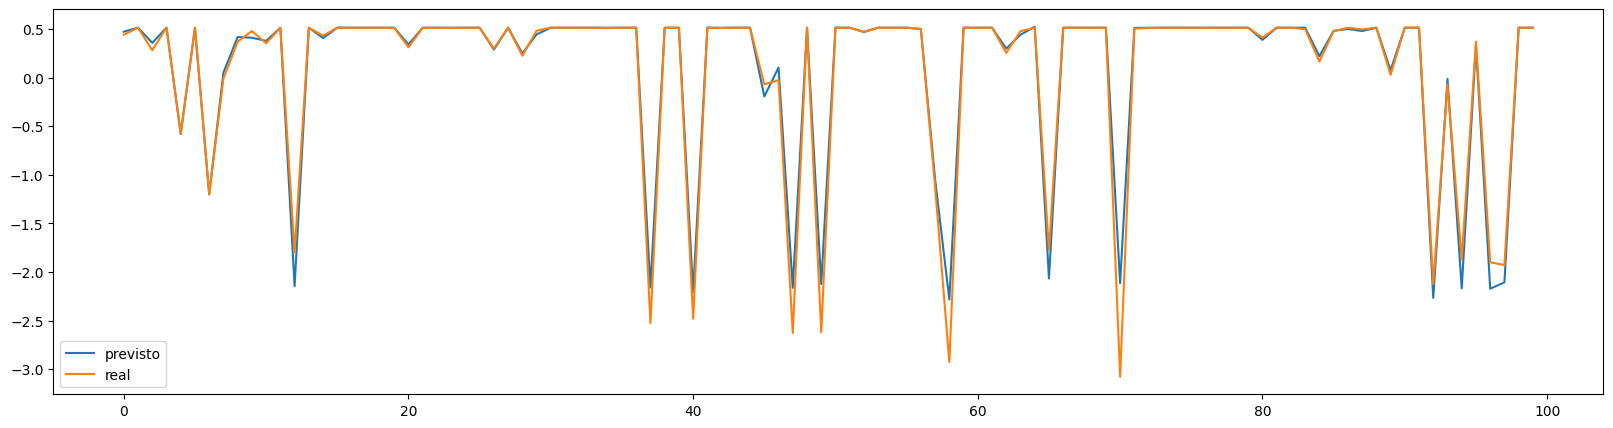

In [33]:
results_train.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

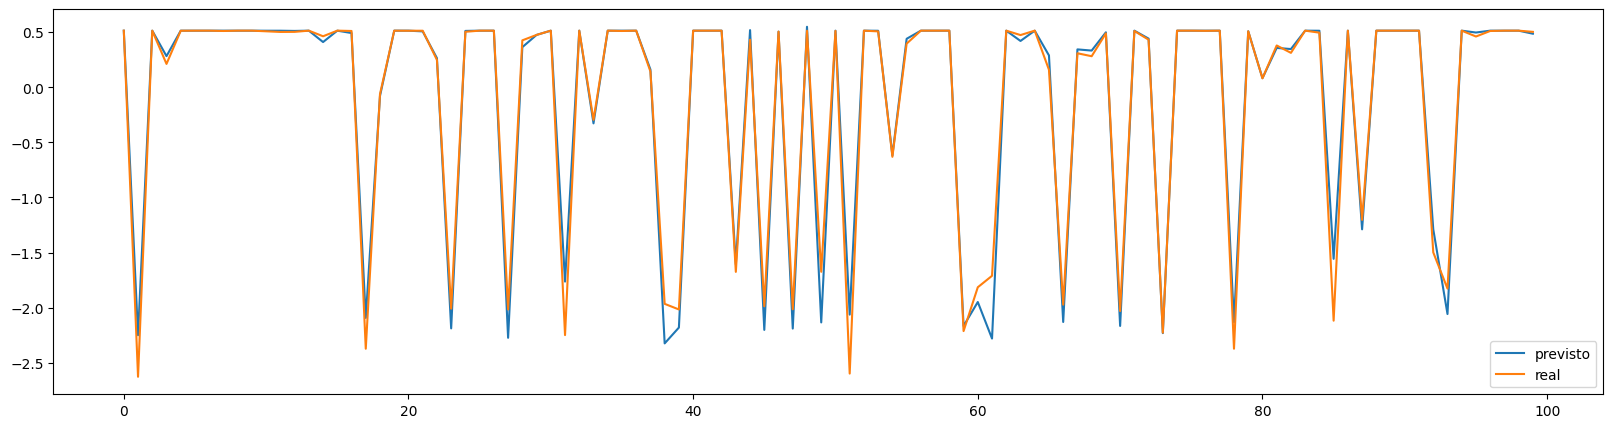

In [34]:
results.iloc[0:100,:].plot(figsize=(20,5)); # somente as 100 primeiras

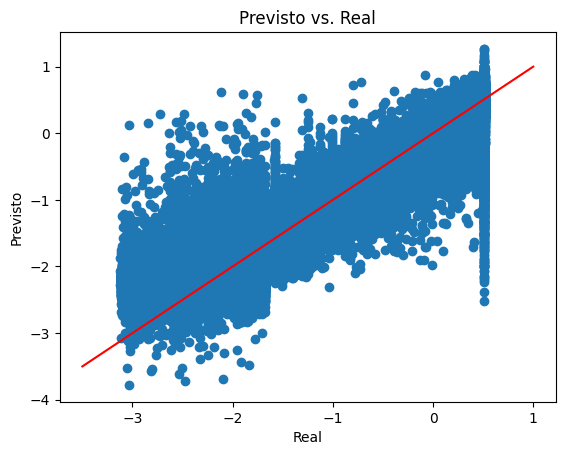

In [35]:
plt.scatter(x=y_train_normalized, y=y_train_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [-3.5, 1]
plt.plot(x, x, color='red'); # reta onde y=x

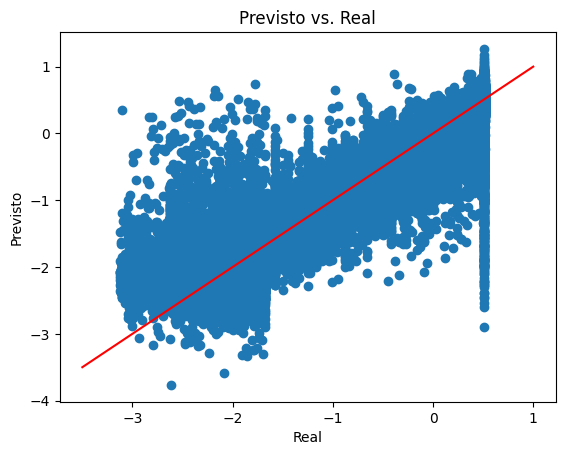

In [36]:
plt.scatter(x=y_test_normalized, y=y_test_predicted)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [-3.5, 1]
plt.plot(x, x, color='red'); # reta onde y=x

In [38]:
r2_score(y_train_normalized, y_train_predicted)

0.9757158626868364

In [39]:
r2_score(y_test_normalized, y_test_predicted)

0.9688922572248757

In [40]:
#desnormalizando e checando os valores de novo:
y_train_predicted_denorm = preprocessParamsY.inverse_transform(y_train_predicted)
y_test_predicted_denorm = preprocessParamsY.inverse_transform(y_test_predicted)

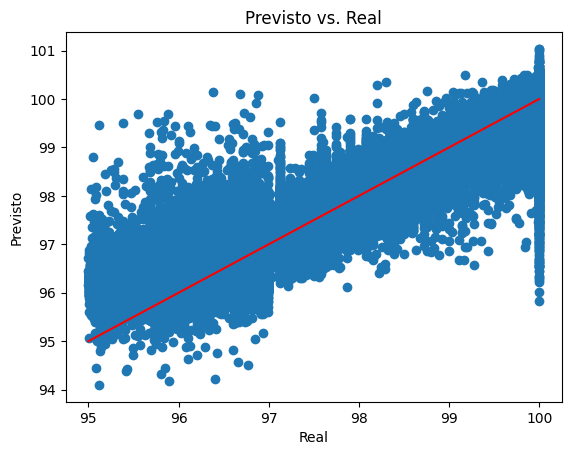

In [41]:
plt.scatter(x=y_train, y=y_train_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

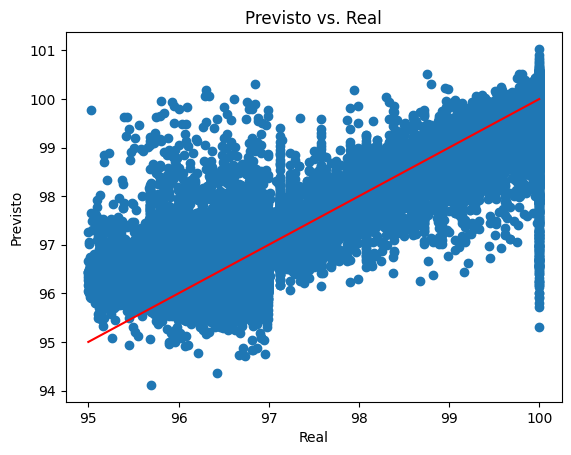

In [43]:
plt.scatter(x=y_test, y=y_test_predicted_denorm)
plt.title('Previsto vs. Real')
plt.xlabel('Real')
plt.ylabel('Previsto')

x = [95, 100]
plt.plot(x, x, color='red'); # reta onde y=x

In [44]:
r2_score(y_train, y_train_predicted_denorm)

0.9757158624998382

In [45]:
r2_score(y_test, y_test_predicted_denorm)

0.9688922574729322